In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install tensorflow-addons
!pip install datasets
!pip install --upgrade accelerate

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import os
import ast
import spacy
import random
import itertools
import matplotlib.pyplot as plt
from typing import List, Tuple

import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoConfig, TFAutoModel

from transformers import DataCollatorForLanguageModeling
from transformers import DebertaTokenizer, DebertaForMaskedLM
from transformers import Trainer, TrainingArguments
from datasets import Dataset

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/TAR - projekt/TAR-dataset/train.csv')
train['annotation'] = train['annotation'].apply(ast.literal_eval) # Construct an object from a string
train['location'] = train['location'].apply(ast.literal_eval) # Construct an object from a string
print(f"train.shape: {train.shape}")

features = pd.read_csv('/content/drive/MyDrive/TAR - projekt/TAR-dataset/features.csv')
print(f"features.shape: {features.shape}")

patient_notes = pd.read_csv('/content/drive/MyDrive/TAR - projekt/TAR-dataset/patient_notes.csv')
print(f"patient_notes.shape: {patient_notes.shape}")

train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')
train['annotation_length'] = train['annotation'].apply(len)
print(f"train.shape: {train.shape}")

train.shape: (14300, 6)
features.shape: (143, 3)
patient_notes.shape: (42146, 3)
train.shape: (14300, 9)


In [ ]:
seed=42
train, test = train_test_split(train[['pn_history', 'pn_num', 'feature_text','annotation_length', 'location']], test_size=0.15, random_state=seed)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
# this functions are from:
# https://www.kaggle.com/yasufuminakama/nbme-deberta-base-baseline-train
# https://www.kaggle.com/code/ammarnassanalhajali/nbme-fine-tuning-deberta-tensorflow

def prepare_location(locations: str) -> List[Tuple[int]]:
    """
    This function returns list of tuples of locations
    """
    location_tuple_list = []
    for location in locations:
        for loc in [s.split() for s in location.split(';')]:
            start, end = int(loc[0]), int(loc[1])
            location_tuple_list.append((start, end))
    
    return location_tuple_list

def prepare_input(pn_history: str, feature_text: str):
    """
    This function tokenizes pn_history and feature text and
    returns numpy array of input_ids and attention_masks
    """
    tokens = tokenizer(
        pn_history,
        feature_text,
        max_length=MAX_LEN,
        padding="max_length",
        add_special_tokens=True,
    )
    
    input_ids = tokens['input_ids']
    attention_mask = tokens["attention_mask"]
    return np.array(input_ids), np.array(attention_mask)

def prepare_labels(pn_history, annotation_length, location_list):
    """
    This function creates labels with are vectors of zeros (no entity)
    and ones (entity)
    """
    tokenized = tokenizer(
        pn_history,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding="max_length",
        return_offsets_mapping=True
    )
    offset_mapping = tokenized["offset_mapping"]
    #print(offset_mapping)
    #print(f'Len of offset: {len(offset_mapping)}')
    label = np.zeros(len(offset_mapping))
    if annotation_length != 0:
        locations = prepare_location(location_list)
        #print(locations)
        for location in locations:
            #print(f'location: {location}')
            start_idx, end_idx = -1, -1
            start, end = location
            for idx in range(len(offset_mapping)):
                if (start_idx == -1) & (start < offset_mapping[idx][0]):
                    start_idx = idx - 1
                if (end_idx == -1) & (end <= offset_mapping[idx][1]):
                    end_idx = idx + 1
            if start_idx == -1:
                start_idx = end_idx
            if (start_idx != -1) & (end_idx != -1):
                label[start_idx:end_idx] = 1
            
    return np.array(label)

In [ ]:
def create_data(dataframe: pd.DataFrame,train=True):
    pn_history = dataframe["pn_history"].values # stavi sve notes u array
    feature_text = dataframe["feature_text"].values # svi featuri u array
    if train:
        annotation_length = dataframe['annotation_length'].values # ak treniram uzmi i duzinu anotacije
        location = dataframe['location'].values # uzmi anotacije
    input_ids = []
    attention_mask = []
    labels = []

    for i in range(len(dataframe)):
        inputs, masks = prepare_input(pn_history[i], feature_text[i])
        input_ids.append(inputs)
        attention_mask.append(masks)
        if train:
            lbls = prepare_labels(pn_history[i], annotation_length[i], location[i])
            labels.append(lbls)
    return {"input_ids":input_ids,"attention_mask":attention_mask}, labels

In [ ]:
MAX_LEN = 512
train, valid = train_test_split(train, test_size=0.1, random_state=seed)
    
train_data, train_labels = create_data(train,train=True)
val_data, val_labels = create_data(valid,train=True)

In [ ]:
MAX_LEN = 512
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.f1 = tfa.metrics.F1Score(num_classes=2, average='micro', threshold=0.50)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, (-1,MAX_LEN))
        y_pred = tf.reshape(y_pred, (-1,MAX_LEN))
        self.f1.update_state(y_true, y_pred)
        
    def reset_state(self):
        self.f1.reset_state()
    
    def result(self):
        return self.f1.result()
    
metrics = [
    F1Score()
]

In [ ]:
save_path = '/content/drive/MyDrive/TAR - projekt/savings'

model_save = tf.keras.callbacks.ModelCheckpoint(
    f'{save_path}/BioClinicalBERT/tuned.h5', 
    save_best_only = True, 
    save_weights_only = True,
    monitor = 'val_f1', 
    mode = 'max',
    verbose = 1
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1', 
    min_delta=1e-5, 
    patience=3, 
    verbose=1,
    mode='max', 
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_f1', 
    factor=0.5, 
    patience=2, 
    mode='max', 
    min_delta=0.001,
    verbose = 1
)

# ---------- Training ----------
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
CLIP_NORM = 1000

In [ ]:
config = AutoConfig.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
def create_model() -> tf.keras.Model:
    input_tokens = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32) # layer za 1d input duljine 512
    attention_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype=tf.int32) # layer za 1d mask

    backbone = TFAutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", config=config)

    out = backbone(input_tokens, attention_mask=attention_mask)[0]
    out = tf.keras.layers.Dropout(0.2)(out)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(out)

    return tf.keras.Model(inputs=[input_tokens, attention_mask], outputs=out)

model = create_model()
model.summary()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, clipnorm=CLIP_NORM)
loss = tf.keras.losses.BinaryCrossentropy(reduction="none")
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

Some layers from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
train_data_X =(np.asarray(train_data['input_ids']),np.asarray(train_data['attention_mask']))          
train_data_Y =np.asarray(train_labels)

valid_data = ((np.asarray(val_data['input_ids']),
              np.asarray(val_data['attention_mask']),
             ),np.asarray(val_labels))

## Train and save the model

In [ ]:
history=model.fit(
            train_data_X,
            train_data_Y, 
            epochs = EPOCHS,
            shuffle=True,
            batch_size = BATCH_SIZE,
            validation_data= valid_data,
            callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/10


684/684 [==============================] - ETA: 0s - loss: 0.0224 - f1: 0.3828
Epoch 1: val_f1 improved from -inf to 0.72166, saving model to /content/drive/MyDrive/TAR - projekt/savings/BioClinicalBERT/tuned.h5
684/684 [==============================] - 245s 280ms/step - loss: 0.0224 - f1: 0.3828 - val_loss: 0.0095 - val_f1: 0.7217 - lr: 2.0000e-05
Epoch 2/10
684/684 [==============================] - ETA: 0s - loss: 0.0079 - f1: 0.7658
Epoch 2: val_f1 improved from 0.72166 to 0.79508, saving model to /content/drive/MyDrive/TAR - projekt/savings/BioClinicalBERT/tuned.h5
684/684 [==============================] - 170s 248ms/step - loss: 0.0079 - f1: 0.7658 - val_loss: 0.0077 - val_f1: 0.7951 - lr: 2.0000e-05
Epoch 3/10
684/684 [==============================] - ETA: 0s - loss: 0.0055 - f1: 0.8391
Epoch 3: val_f1 improved from 0.79508 to 0.82398, saving model to /content/drive/MyDrive/TAR - projekt/savings/BioClinicalBERT/tuned.h5
684/684 [==============================] - 168s 245ms/st

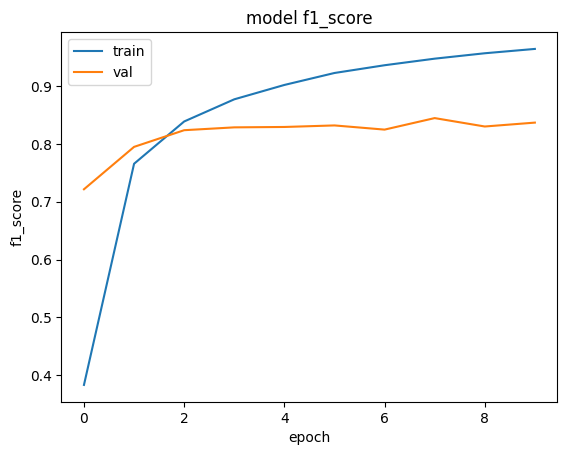

In [ ]:
# Summarizes history for accuracy
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

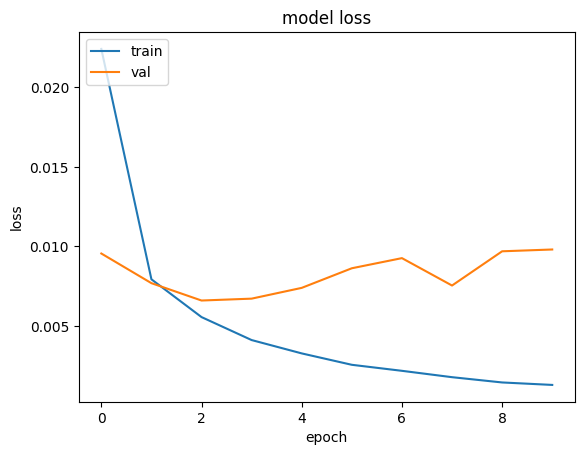

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()